# Automatic Differentiation for Matrices (Differentiable Programming)

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements)
  * [Prerequisites](#Prerequisites)
  * [Knowledge](#Knowledge)
  * [Python Modules](#Python-Modules)
* [Exercises](#Exercises)
  * [Derivative of the dot product](#Derivative-of-the-dot-product)
  * [Autodiff class Node](#Autodiff-class-%3Ccode%3ENode%3C%2Fcode%3E)
  * [2D Helper](#2D-Helper)
  * [Operators](#Operators)
  * [Operators - Multiply](#Operators---multiply)
  * [Operators - Dot product](#Operators---Dot-product)
  * [Operators - Square](#Operators---Square)
* [Additional operators](#Additional-operators)
* [Node class for a small neural net](#Node-class-for-a-small-neural-net)
* [Literature](#Literature)
* [Licenses](#Licenses)


## Introduction
In this notebook you will implement a class that supports automatic differentiation for matrices.

The idea is to implement individual operators like $+$, $*$ and the dot product and their derivatives. You can chain these operators together and construct expressions such as
`C = A.dot(B + 3)`. These expressions apply the chain rule on the operators they're made up of to compute the derivatives.

## Requirements

### Prerequisites
* A notebook [Automatic Differentiation for Scalars](./exercise_automatic_differentiation_scalar.ipynb) exists in which you implement a class that supports automatic differentiation for **scalar** values rather than **2D values**. You should complete the notebook on scalars first to get familiar with implementing an autodiff class and its operators. Then, move on to this notebook to tackle 2D values.

### Knowledge
* This notebook deals with computational graphs, the chain rule and backpropagation. A recommended read on the topic is [Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/) by C. Olah [[OLA15]](#OLA15)

* The Python implementation of the autodiff class is inspired by MXNet and discussed in-depth in the article [Deep Learning Programming Style](http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html) by Apacahe MXNet [[AP17]](#AP17)

### Python Modules

In [ ]:
import numpy as np
import numbers
import operator

from matplotlib import pyplot as plt
%matplotlib inline

## Exercises

### Derivative of the dot product
In the **forward** pass we have the following expressions with a matrix $W$ and function $f$. The input $\vec{x}$ has $j$ features, the output $\vec{y}$ has $i$ features. So $y$ maps a $j$-dimensional vector to an $i$-dimensional vector.

$$
y : \mathbb{R}^j \to \mathbb{R}^i
$$

$$
\vec y = W \cdot \vec x
$$

$$
f(\vec y) = f(\vec y(\vec x))
$$

In the **backward** pass, we want to compute the gradient (error responsibilities). The gradient (error responsibilities) w.r.t. $\vec y$ is

$$
\nabla_y f = \vec \delta^{(y)} = \left(\frac{\partial f}{\partial y_1}, \frac{\partial f}{\partial y_2}, \dots,  \frac{\partial f}{\partial y_i}\right)^T  .
$$

The gradient (error responsibilities) w.r.t. $\vec x$ is

$$
\nabla_x f = \vec \delta^{(x)} = \left(\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \dots,  \frac{\partial f}{\partial x_j}\right)^T .
$$


**Task:**
Show that the gradient w.r.t $\vec x$ is

$$
\vec \delta^{(x)} = W^T \vec \delta^{(y)}.
$$

**Hint:**

The chain rule tells us that
$$
\vec \delta^{(x)} = \frac{\partial f}{\partial \vec{y}} \cdot \frac{\partial \vec{y}}{\partial \vec{x}}.
$$

Let's tackle the derivative of the dot product $\frac{\partial \vec{y}}{\partial \vec{x}}$. Consider the matrix multiplication $\vec y = W \cdot \vec x$ for a single input sample $\vec{x}$. The input has 3 features $x_1$, $x_2$ and $x_3$ and the output has two fetaures $y_1$ and $y_2$

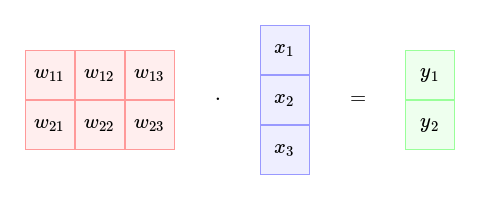

We want to derive each output feature $y_i$ with respect to $\vec{x}$. So let's expand the features of $\vec{y}$ into a vector.
$$
\frac{\partial \vec{y}}{\partial \vec{x}}  =    
\begin{bmatrix}
\frac{\partial y_1}{\partial \vec{x}}\\
\frac{\partial y_2}{\partial \vec{x}}\\
\end{bmatrix}
   $$
   
Let's take it a step further - we want derive **each output feature** with respect to **each input feature**. So let's expand the features of $\vec{x}$ as columns.

$$
\left[\frac{\partial \vec{y}}{\partial \vec{x}}\right] =    
\begin{bmatrix}
\frac{\partial y_1}{\partial \vec{x}}\\
\frac{\partial y_2}{\partial \vec{x}}\\
\end{bmatrix} = 
\begin{bmatrix}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \frac{\partial y_1}{\partial x_3}\\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \frac{\partial y_2}{\partial x_3}\\
\end{bmatrix}
   $$

This gives us a matrix of all partial derivatives, which is also called the **Jacobian matrix**. To get the actual values of the derivatives, let's look at how the output features were computed.

$$
y_1 = w_{11} * x_1 + w_{12} * x_2 + w_{13} * x_3\\
y_2 = w_{21} * x_1 + w_{22} * x_2 + w_{23} * x_3
$$


Now, let's focus on the single input feature $x_1$. The graph below shows how $x_1$ contributes to the output.

<img src="https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/oliver/dp_matrix_pic1.png" width="512" alt="internet connection needed">

To derive $f$ with respect to $x_1$, we must sum over all paths to which $x_1$ contributed. So:
$$
\delta_1^{(x)} = \frac{\partial f}{\partial y_1} * \frac{\partial y_1}{\partial x_1} + \frac{\partial f}{\partial y_2} * \frac{\partial y_2}{\partial x_1}
$$
You find the values for all these partial derivatives in $\delta^{(y)}$ (the error responsibilities for $y$) and the Jacobian matrix.


### Row vectors

In the previous exercise, $\vec x$ was a column vector. If $\vec x$ is a row vector instead, the order of $\vec x$ and $W$ is reversed in the forward pass.

$$
y : \mathbb{R}^j \to \mathbb{R}^i
$$

$$
\vec y = \vec x \cdot \vec W
$$

$$
f(\vec y) = f(\vec y(\vec x))
$$

### Task

How do we calculate $\vec \delta^{(x)}$ in vectorized form now?

### Autodiff class `Node` 

Deep learning frameworks support automatic differentiation via backpropagation through the computational graph.  To demonstrate how autodiff works we implement an autodiff python class `Node`.

The syntax of this class should be familiar to you from the exercise [Automatic Differentiation for Scalars](./exercise_automatic_differentiation_scalar.ipynb) (see [Requirements](#Requirements)) - so we won't go as much into detail about it again.

Note: We have to add multiple path to the same variable as the multivariable chain rule tells us. For the implementation we store the partial derivatives in a python `dict`ionary. We need a helper function `combine_dicts` for taking the _multivariate chain rule_ into account:

In [ ]:
def combine_dicts(a, b, op=operator.add):
    x = (list(a.items()) + list(b.items()) +
        [(k, op(a[k], b[k])) for k in set(b) & set(a)])
    return {x[i][0]: x[i][1] for i in range(0, len(x))}

In [ ]:
# Here you see how combine dicts work
a = {'a': 2, 'b':3, 'c':4}
b = {'a': 5, 'c':6, 'x':7}
combine_dicts(a, b)

In [ ]:
# and another example
A = {'a':-1.3, 'b':-4, 'c':3}
B = {'b':3, 'c':4, 'd':5}
combine_dicts(A,B)

### Node class
Below is a skeleton for the node class and a number of helper functions.

In [ ]:
class Node(object):    
    def __init__(self, value, name=None):      
        value = Node._wrap_2d(value)
        self._set_variables(name, value)
        # only 2D-Arrays are supported at the moment
        assert len(self.shape)==2

    # Helper functions
    
    # Sets variables and provides a default grad function
    def _set_variables(self, name, value):
        self.value = value
        self.shape = value.shape
        self.dtype = value.dtype
        self.name = name
        if name:
            self.grad = lambda g : {name : g}
        else: 
            self.grad = lambda g : {}
    
    def _broadcast_g_helper(o, o_):# broadcasting make things slightly more complicated
        if o_.shape[0] > o.shape[0]:
            o_ = o_.sum(axis=0).reshape(1,-1)
        if o_.shape[1] > o.shape[1]:
            o_ = o_.sum(axis=1).reshape(-1,1)
        return o_
    
    # When two branches lead to a node,
    # this function is used to combine the gradients from
    # both branches leading to the node.
    def _set_grad(self_, g_total_self, other, g_total_other):
        g_total_self = Node._broadcast_g_helper(self_, g_total_self)
        x = self_.grad(g_total_self)
        g_total_other = Node._broadcast_g_helper(other, g_total_other)
        x = combine_dicts(x, other.grad(g_total_other))
        return x

### 2D Helper

The value of each Node is a 2D numpy array. This consistency is important so all operators we're going to implement handle 2D numpy arrays. Node objects are initialized with a `value` and optionally a name.

**Task:** Implement the `_wrap_2d` helper function.
* If the argument `value` is a scalar, return `value` as a 2D numpy array (shape (1,1))
* If `value` is a 1D (numpy) array, return it as a 2D column vector (shape (n,1))

In [ ]:
# Ensure that the value is a 2D numpy array.
# Scalars and 1D values are wrapped as a 2D array.
def _wrap_2d(value):
    raise NotImplementedError()

Node._wrap_2d = _wrap_2d

In [ ]:
assert np.array_equal([[3]], Node(3).value)
assert np.array_equal([[3]], Node(np.array([3])).value)
assert np.array_equal([[3]], Node(np.array([[3]])).value)

assert Node(np.array([1,2,3])).shape == (3,1)

### Operators

Now we can start adding operators and their derivatives. The syntax should be familiar to you from the exercise on scalar values, see [Automatic Differentiation for Scalars](./exercise_automatic_differentiation_scalar.ipynb) for a more detailed explanation.

The only two things that have changed:
* The `value` of each node is a 2D array.
* We use a helper function `_set_grad` to call the `grad` function of each input and combine the result of the two branches. The function also takes care of broadcasting.

In [ ]:
def __add__(self, other):
    if isinstance(other, numbers.Number):
        other = Node(np.array([[other]]))
    ret = Node(self.value + other.value)
    def grad(g):
        # derivative root w.r.t self and other
        g_total_self = g
        g_total_other = g
        # combine the branches
        x = Node._set_grad(self, g_total_self, other, g_total_other)
        return x
    ret.grad = grad
    return ret

Node.__add__ = __add__

If the argument is a number, we wrap it as a Node so both of the expressions `node + 1` and `node + Node(1)` are equivalent and valid.

In [ ]:
node = Node(np.arange(6).reshape((2,3)))
a = (node + 1).value
b = (node + Node(1)).value
assert np.array_equal(a,b)

The way we compute gradients is similar to how we handled scalars, see [Automatic Differentiation for Scalars](./exercise_automatic_differentiation_scalar.ipynb) for a more detailed explanation.

We use the helper function
```Node._set_grad(self, g_total_self, other, g_total_other)``` which
* handles broadcasting
* calls self.grad(g_total_self)
* calls other.grad(g_total_other)

This produces a dictionary of gradients for each branch leading up to `C`. The function combines these gradients and returns the combined dictionary.

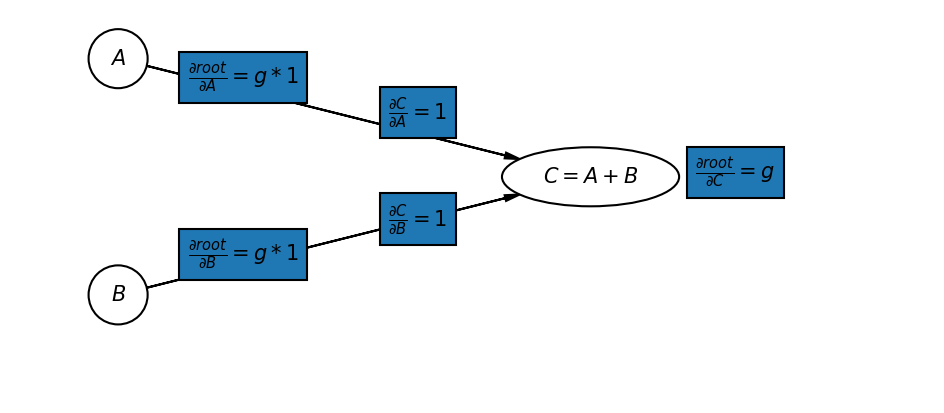

### Operators - Multiply

**Task:** Implement the multiplication operator.

In [ ]:
def __mul__(self, other):
    raise NotImplementedError()

Node.__mul__ = __mul__

In [ ]:
a = Node(np.array([[1,1,1], [2,2,2]]), "A")
b = Node(np.array([[10,20,30]]), "B")
c = a * b

assert np.array_equal(c.value, np.array([[10, 20, 30],[20, 40, 60]]))
grads = c.grad(1) # gradient of C w.r.t A and B
assert np.array_equal(grads['A'], np.array([[10,20,30]]))
assert np.array_equal(grads['B'], np.array([[3,3,3]]))

### Operators - Dot product

**Task:** Implement the dot product. The exercise [Derivative of the dot product](#Derivative-of-the-dot-product) mentions how to differentiate the dot product operator.

In [ ]:
def dot(self, other):
    raise NotImplementedError()

Node.dot = dot

Verify your implementation.

In [ ]:
a = Node(np.array([[1,2,3],
       [4,5,6]]), "a")
b = Node(np.array([[10,10],
        [20,20],
        [30,30]]), "b")
c = dot(a,b)
assert np.array_equal(c.value, np.array([[140, 140], [320, 320]]))
assert np.array_equal(c.grad(1)['a'], np.array([[10, 20, 30], [10, 20, 30]]))
assert np.array_equal(c.grad(1)['b'], np.array([[1, 4], [2, 5], [3, 6]]))

### Operators - Square

**Task:** Implement the square operator.

In [ ]:
def square(self):
    raise NotImplementedError()
    
Node.square = square

### Additional operators

We extend the Node class with some more operators (which are already fully implemented).

In [ ]:
def __radd__(self, other):
    return Node(other) + self

def __sub__(self, other):
    if isinstance(other, numbers.Number):
        other = Node(other)
    ret = self + (other * -1.)   
    return ret

def __rsub__(self, other):
    if isinstance(other, numbers.Number):
        other = Node(other) 
        return other - self
    raise NotImplementedError()      

def __rmul__(self, other):
    if isinstance(other, numbers.Number):
        return Node(other) * self
    raise NotImplementedError()

def concatenate(self, other, axis=0):
    assert axis in (0,1) # TODO
    ret = Node(np.concatenate((self.value, other.value), axis=axis))
    def grad(g):
        if axis == 0: 
            g_total_self = g[:self.shape[0]] 
            g_total_other = g[self.shape[0]:]
        elif axis == 1:
            g_total_self = g[:, :self.shape[1]] 
            g_total_other = g[:, self.shape[1]:]
        x = Node._set_grad(self, g_total_self, other, g_total_other)
        return x
    ret.grad = grad
    return ret

def __truediv__(self, other):
    if isinstance(other, numbers.Number):
        other = Node(np.array([[other]]))
    ret = Node(self.value / other.value) 
    def grad(g):
        g_total_self = g / other.value
        g_total_other = -1 * self.value * g / (other.value**2)
        x = Node._set_grad(self, g_total_self, other, g_total_other)
        return x
    ret.grad = grad
    return ret

def __rtruediv__(self, other):
    if isinstance(other, numbers.Number):
        other = Node(other)
        return other/self
    raise NotImplementedError()

def __neg__(self):
    return self * -1.

def transpose(self):
    ret = Node(self.value.T)
    def grad(g):
        x = self.grad(g.T)
        return x
    ret.grad = grad
    return ret       

def exp(self):
    ret = Node(np.exp(self.value))
    def grad(g):
        assert self.shape == g.shape
        x = self.grad(np.exp(self.value) * g)
        return x
    ret.grad = grad
    return ret         

def log(self):
    ret = Node(np.log(self.value))
    def grad(g):
        assert self.shape == g.shape
        x = self.grad(1./self.value * g)
        return x
    ret.grad = grad
    return ret     

def sqrt(self):
    ret = Node(np.sqrt(self.value))
    def grad(g):
        assert self.shape == g.shape
        x = self.grad(0.5 * (1/np.sqrt(self.value)) * g)
        return x
    ret.grad = grad
    return ret     

def sum(self, axis=None):
    if axis is None:
        return self._sum_all()
    assert axis in (0,1)
    return self._sum(axis)


def _sum_all(self):
    ret = Node(np.sum(self.value).reshape(1,1))
    def grad(g):
        x = self.grad(np.ones_like(self.value) * g)
        return x
    ret.grad = grad
    return ret

def _sum(self, axis):
    ret = self.value.sum(axis=axis)
    if axis==0: 
        ret = ret.reshape(1, -1)
    else:
        ret = ret.reshape(-1, 1)
    ret = Node(ret)
    def grad(g):
        x = self.grad(np.ones_like(self.value) * g)
        return x
    ret.grad = grad
    return ret  

def relu(self):
    self.mask = self.value > 0.
    ret = Node(self.mask * self.value)
    def grad(g):
        assert self.shape == g.shape
        x = self.grad(self.mask * g)
        return x
    ret.grad = grad
    return ret    

def softmax(self):
    ret = self.exp() / self.exp().sum(axis=1)
    np.testing.assert_almost_equal(ret.value.sum(axis=1), 1.)
    return ret

def sigmoid(self):
    return 1./(1. + self.exp())

Node.__radd__ = __radd__
Node.__sub__ = __sub__
Node.__rsub__ = __rsub__
Node.__rmul__ = __rmul__
Node.concatenate = concatenate
Node.__truediv__ = __truediv__
Node.__rtruediv__ = __rtruediv__
Node.__neg__ = __neg__
Node.transpose = transpose
Node.exp = exp
Node.log = log
Node.sqrt = sqrt
Node.sum = sum
Node._sum_all = _sum_all
Node._sum = _sum
Node.relu = relu
Node.softmax = softmax
Node.sigmoid = sigmoid

### Node class for a small neural net

We construct the computational graph for the forward pass and the loss function using `Node` objects and their operators.

The cross-entropy cost
$$
- (y * log(p) + (1 - y) * log(1-p))
$$
is expressed in the code below as
```python
loss0 = t * out.log() * -1. - (t*-1.+1.) * (out*-1.+1.).log() 
```
which looks a bit cumbersome, but we're making use of the operators we implemented in the `Node` class.

In [ ]:
def NN_model(theta, x, y=None):

    Node.NodeStore = dict()
    
    X = Node(x) # no name -> no grad 
    
    w0 = Node(theta["w0"], "w0")
    b0 = Node(theta["b0"], "b0")
    w1 = Node(theta["w1"], "w1")
    b1 = Node(theta["b1"], "b1")
    
    h0 = (X.dot(w0) + b0).relu()
    h1 = (h0.dot(w1) + b1)
    out = h1.sigmoid() 
    
    if y is not None:
        t = Node(y)
        assert t.shape == out.shape
        #loss0 = t * out.log() * -1. # if t is one hot encoded
        loss0 = t * out.log() * -1. - (t*-1.+1.) * (out*-1.+1.).log() 
        loss = loss0.sum()
        return out, loss 
    
    return out

Once we've computed the loss, we call its grad function `loss.grad(np.ones_like(loss.value))` and get the gradients for all parameters in the forward pass. We apply these gradients in gradient descent.

In [ ]:
def gradient_descent(x,y,epochs,theta,alpha=0.001):
    out, loss = NN_model(theta, x, y.reshape(-1,1))
    for i in range(epochs):
        # forward pass
        old_loss_value = loss.value    
        out, loss = NN_model(theta, x, y.reshape(-1,1))
        if i%1000==0:
            print (loss.value)
        grad = loss.grad(np.ones_like(loss.value))
        for g in grad:
            gradient = grad[g]
            assert theta[g].shape == gradient.shape   
            theta[g] -= alpha * gradient 
    return theta

Setup for an example:

In [ ]:
# Generate NN training data 
# Polar coordinates: r, phi
def get_x(nb, c):
    assert (c==0 or c==1)
    r = c + np.random.rand(nb)
    phi = np.random.rand(nb) * 2 * np.pi
    return np.concatenate(((r * np.sin(phi)).reshape(-1,1), (r * np.cos(phi)).reshape(-1,1)), axis=1)

def get_data(nb_1, nb_2):
    x_0 = get_x(nb_1, 0)
    x_1 = get_x(nb_2, 1)
    X = np.concatenate((x_0, x_1), axis=0)
    t = np.zeros(len(X))
    t[len(x_0):] = 1
    p = np.random.permutation(range(len(X)))
    # permute the data
    X = X[p]
    t = t[p]
    return X, t

def random_theta(nb_hidden=10):
    theta = dict()
    theta["w0"] = np.random.randn(2,nb_hidden)*0.2
    theta["b0"] = np.random.randn(1,nb_hidden) + 1.
    theta["w1"] = np.random.randn(nb_hidden,1)*0.2
    theta["b1"] = np.random.randn(1,1) + 1.
    return theta

def plot_contour(x_0, x_1, theta, data_type):
    delta = 0.025
    a = np.arange(-2.5, 2.5, delta)
    b = np.arange(-2.5, 2.6, delta)
    A, B = np.meshgrid(a, b)
    Z = np.ndarray(A.shape)
    
    x_ = np.dstack((A,B)).reshape(-1, 2)
    out = NN_model(theta, x=x_)
    Z = out.value.reshape(A.shape)

    plt.figure(figsize=(8,8))
    CS = plt.contour(A, B, Z, (0.2,0.50,0.8), colors=('b', 'green', 'r'))
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Prediction surface plot with %s'%data_type)
    plt.scatter(x_0[:,0], x_0[:,1], label='Class 0', color='b') 
    plt.scatter(x_1[:,0], x_1[:,1], label='Class 1', color='r') 
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    

In this example we draw points from a circle using polar coordinates $r$ and $\phi$ with some added noise.

* blue: Points drawn with radius $0 + noise$ generally end up close to the center and are given the target class 0.
* red: Points drawn with radius $1 + noise$ are usually farther from the center and given the target class 1.

We then convert the polar coordinates ($r$,$\phi$) to cartesian coordinates ($x$,$y$) and return these points and their target classes as training data.

In [ ]:
X_train, t_train = get_data(30, 35)
X_test, t_test = get_data(20, 20)
t_train_one_hot = np.zeros([t_train.shape[0], 2], dtype=int)
t_train_one_hot[list(range(t_train.shape[0])), t_train.astype(int)]=1

x_0,x_1 = X_train[t_train==0], X_train[t_train==1]
plt.scatter(x_0[:,0], x_0[:,1], label='Class 0', color='b') 
plt.scatter(x_1[:,0], x_1[:,1], label='Class 1', color='r');

Now we'll use gradient descent to map points in (x,y) coordinates to a target class 0 or 1.
In the plot below, the green line marks all points (x,y) where the output of the model is 0.5. It serves as a decision boundary for the model.

In [ ]:
theta_fit = gradient_descent(X_train,t_train,5000,random_theta(),alpha=0.002)
plot_contour(X_test[t_test==0], X_test[t_test==1], theta_fit, 'train data')

# Literature

<table>
    <tr>
        <td>
            <a name="AP17"></a>[AP17]
        </td>
        <td>
            Apache MXNet, "Deep Learning Programming Style". [Online]. Available: <a href="http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html">http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html</a> [Accessed: 17-Feb- 2019]
        </td>
    </tr>
    <tr>
        <td>
            <a name="OLA15"></a>[OLA15]
        </td>
        <td>
            C. Olah, "Calculus on Computational Graphs: Backpropagation" - Blog Article, August 31, 2015. [Online] Available: <a href='http://colah.github.io/posts/2015-08-Backprop/'>http://colah.github.io/posts/2015-08-Backprop/</a> [Accessed: 17- Feb- 2019]
        </td>
    </tr>
    <tr>
        <td>
            <a name="BAY18"></a>[BAY18]
        </td>
        <td>
            Atilim Gunes Baydin, Barak A. Pearlmutter, Alexey Andreyevich Radul, Jeffrey Mark Siskind, "Automatic differentiation in machine learning: a survey", Journal of Machine Learning Research 18 (2018) 1-43  Apr. 2018. [Online]. Available: <a href="http://jmlr.org/papers/volume18/17-468/17-468.pdf">http://jmlr.org/papers/volume18/17-468/17-468.pdf</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="LM"></a>[LM]
        </td>
        <td>
            Erik Learned-Miller, 'Vector, Matrix, and Tensor Derivatives'. [Online]. Available: <a href="http://cs231n.stanford.edu/vecDerivs.pdf">http://cs231n.stanford.edu/vecDerivs.pdf</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="KAR"></a>[KAR]
        </td>
        <td>
            A.Karpathy, Lecture Notes CS 231 Convolutional Neural Networks for Visual Recognition: Backpropagation, Year Published. [Online]. Available: <a href="http://cs231n.github.io/optimization-2/">http://cs231n.github.io/optimization-2/)</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="BFO17"></a>[BFO17]
        </td>
        <td>
            B. Fortuner “Loss Functions,” Loss Functions, 2017 Revision 5f00adef. [Online]. Available: <a href='https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html'>https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html</a>. [Accessed: 02-May-2019]. 
        </td>
    </tr>
    
    
    
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Automatic Differentiation for Matrices_ <br/>
by _[Christian Herta](https://www.htw-berlin.de/forschung/online-forschungskatalog/publikationen/person/?eid=2605), Diyar Oktay_ <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 _[Christian Herta](https://www.htw-berlin.de/forschung/online-forschungskatalog/publikationen/person/?eid=2605)_, Diyar Oktay

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.